In [1]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
# from sklearn.externals import joblib
import joblib
# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Configurations
path='./audio/london_phill_dataset_multi/'

C:\Users\venky\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\venky\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\venky\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./audio/london_phill_dataset_multi/


In [3]:
# Get Labels
labels =[]
classes=['flute','sax','oboe', 'cello','trumpet','viola']
color_dict={'cello':'blue', 'flute':'red', 'oboe':'green', 'trumpet':'black', 'sax':'magenta', 'viola':'yellow'}
color_list=[]
for filename in files:
    #print(filename);
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            #print(color_dict[name])

            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

In [4]:
# print(labels)

In [5]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


In [6]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

In [7]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

In [8]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_025_forte_arco-normal.mp3
get 2 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_025_fortissimo_arco-normal.mp3


C:\Users\venky\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


get 3 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
get 4 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_025_mezzo-piano_arco-normal.mp3
get 5 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_025_pianissimo_arco-normal.mp3
get 6 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_05_forte_arco-normal.mp3
get 7 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_05_fortissimo_arco-normal.mp3
get 8 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_05_mezzo-piano_arco-normal.mp3
get 9 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_05_pianissimo_arco-normal.mp3
get 10 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_15_forte_arco-normal.mp3
get 11 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_15_pianissimo_arco-normal.mp3
get 12 of 600 = ./audio/london_phill_dataset_multi/cello\cello_A2_15_piano_arco-normal.mp3
get 13 of 600 = ./audio/london_phill_dataset_

In [9]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (600, 13)


In [10]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [11]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
#with open(filename, "rb") as f:
#    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

# Save feature_vectors for future use
with open(filename, "wb") as f:
    pickle.dump( scaled_feature_vectors, f)

In [12]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    # print("TRAIN:", train_index, "TEST:", test_index)
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [13]:
# print(splits)

In [14]:
print(train_set[0])
print(train_classes[0])
#Test SEt
print(test_set[0])
print(test_classes[0])


[ 0.32131457  1.8526993   2.3936152   0.736074    1.4063234   1.3919946
  1.2103474  -0.05785239  0.74226147  0.15402226 -0.25533307 -0.99549407
 -0.66653365]
0
[-0.15310594  1.1175615   1.2276691   1.2003256   1.0034604   0.18615781
 -0.16341415  0.28683147 -0.5191648  -0.5180154  -0.49637583 -0.39693362
  0.20604444]
5


In [15]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


In [16]:
# SVM
#model_svm = LinearSVC(random_state=0, tol=1e-5, max_iter=5000)
svclassifier = SVC(kernel='rbf', C = 10.0, gamma=0.1) 

In [17]:
# SVM
#model_svm.fit(train_set, train_classes);
svclassifier.fit(train_set, train_classes);

In [18]:
print("SVM Training Complete  testset shape")
print(test_set.shape)
print("SVM Training Complete  test classes shape")
print(test_classes.shape)
print("SVM Training Complete test calsses")
print(test_classes)
print("SVM Training Complete test set")
print(test_set)

SVM Training Complete  testset shape
(150, 13)
SVM Training Complete  test classes shape
(150,)
SVM Training Complete test calsses
[5 4 4 3 5 2 2 3 1 2 0 1 0 5 4 2 5 0 0 0 0 1 4 3 4 1 3 5 5 2 5 5 4 1 5 5 2
 1 2 1 3 1 2 4 2 2 0 2 0 0 4 0 0 3 5 3 0 1 1 0 3 3 5 2 1 4 3 3 1 1 5 5 5 5
 1 2 4 0 5 1 4 0 1 2 1 5 4 3 3 1 2 4 0 4 1 3 3 3 4 4 3 1 2 4 0 5 3 0 0 3 4
 2 4 3 1 2 1 4 5 0 2 4 3 4 4 3 2 5 5 5 0 2 3 4 0 2 0 5 3 1 2 2 3 4 2 1 5 1
 0 0]
SVM Training Complete test set
[[-0.15310594  1.1175615   1.2276691  ... -0.49637583 -0.39693362
   0.20604444]
 [-1.3663528  -0.12673405  1.4346119  ... -0.09343955 -0.2288431
  -0.33119193]
 [-1.2735192  -1.2656115   0.22450997 ...  0.5322631   0.03655329
  -0.42954406]
 ...
 [ 1.034729   -0.4375041  -0.91426724 ...  0.58870417  0.24468334
  -0.4098455 ]
 [ 0.08841936  0.2681031   1.5185682  ... -0.36918265 -0.8862313
  -1.1608536 ]
 [-0.156196    1.1705191   1.8584832  ... -0.6875179  -1.1374208
  -1.3658761 ]]


In [19]:
# Save
joblib.dump(svclassifier, 'trainedSVM.joblib')
#Load
# svclassifier = joblib.load('filename.joblib') 

['trainedSVM.joblib']

In [20]:
# Predict using the Test Set
#predicted_labels = model_svm.predict(test_set)
predicted_labels = svclassifier.predict(test_set)

In [21]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [1.  1.  1.  1.  1.  0.8]
Precision:  [0.86206897 1.         1.         1.         0.96153846 1.        ]
F1-Score:  [0.92592593 1.         1.         1.         0.98039216 0.88888889]
Accuracy: 0.97  , 145
Number of samples: 150


In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [23]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

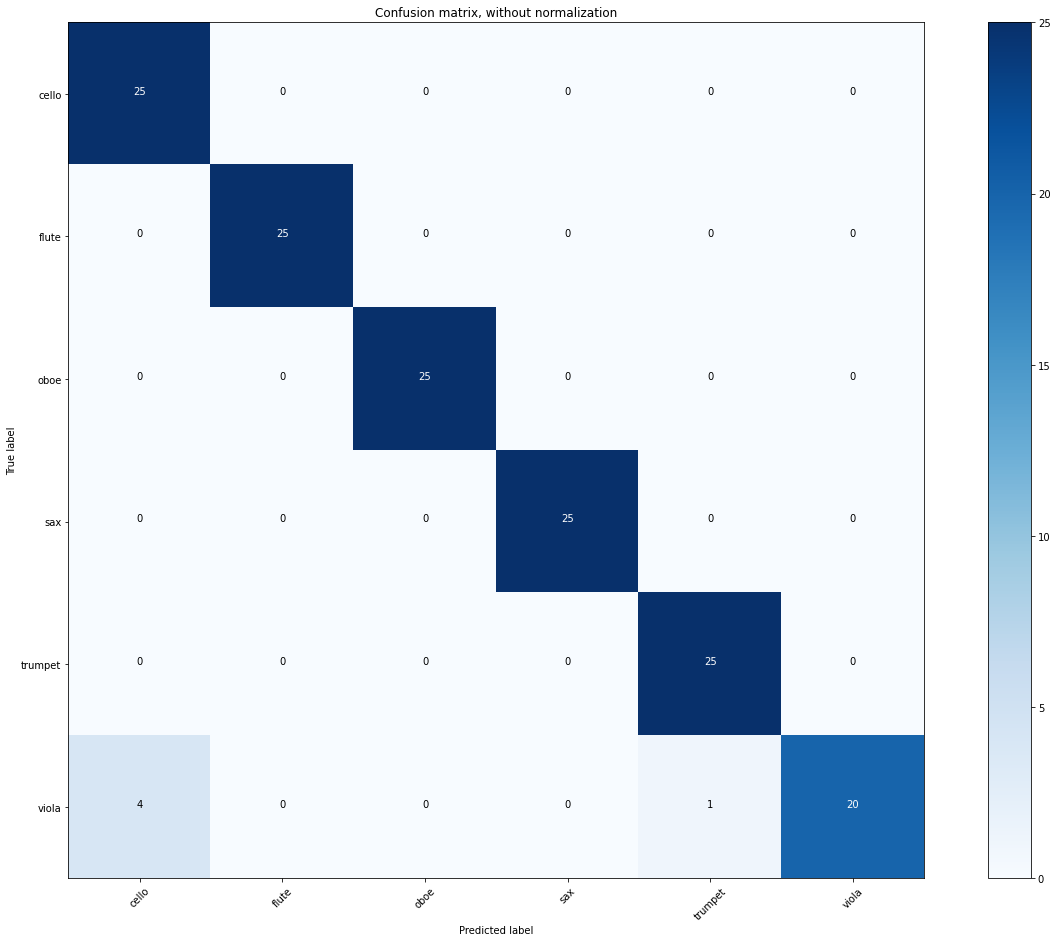

In [24]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [25]:
#! 0.97 SVM
import joblib

In [26]:
svclassifier = joblib.load('trainedSVM.joblib') 

In [28]:
print(test_set[140])

[-0.92 -0.21 -0.57 -1.4   0.6  -1.05 -0.26  0.14  1.58  2.03  2.66  2.5
  2.31]


In [27]:
print("Prediction:  "+list(labelencoder.classes_)[int(svclassifier.predict([test_set[140]]))])
print("Actual:  "+list(labelencoder.classes_)[int(test_classes[140])])

Prediction:  oboe
Actual:  oboe
